# Saudi Arabia Weather Forecasting:
- Part 2: Forecast weather info (barometer, humidity, temperature, visibility, wind) for any Saudi city **(Multivariate time series forecasting).**

_Auther: Esraa Madi_


-------

In [1]:
# import libs
import pandas as pd
import pickle
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
def plot_series(time, series, fig_title, x_label="Time", y_label="Value", format="-", start=0, end=None):
    """Function to plot time series data"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(fig_title)
    plt.grid(True)

In [3]:
# ask access for read file from drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# load cleaned data 
infile = open('/content/gdrive/My Drive/Colab Notebooks/datasets/clean_cities_dataset','rb')
df_cities_lst = pickle.load(infile)
cities = pickle.load(infile)
infile.close()

OSError: ignored

In [5]:
# or just load it from local
from google.colab import files
infile = files.upload()

Saving clean_cities_dataset to clean_cities_dataset


In [6]:
file_ = io.BytesIO(infile['clean_cities_dataset'])
df_cities_lst = pickle.load(file_)
cities = pickle.load(file_)

In [7]:
# show some data
df_cities_lst[0].head()

,barometer,humidity,temp,visibility,wind,city,weather
2017-01-01 00:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 03:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 06:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 09:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear
2017-01-01 12:00:00,1018.0,64.0,17.0,16.0,11.0,Qassim,Clear


In [8]:
# Saudi cities
cities

['Qassim',
 'Hail',
 'Madina',
 'EP',
 'Riyadh',
 'Mecca',
 'Tabuk',
 'Assir',
 'Northern boarder',
 'Jazan',
 'Najran',
 'Baha',
 'Jawf']

In [16]:
# let's start by forcastion weather info of Baha city
city_index = cities.index('Baha')
city_index

11

In [17]:
# number of rows we have for Baha
df_cities_lst[city_index].shape

(6793, 7)

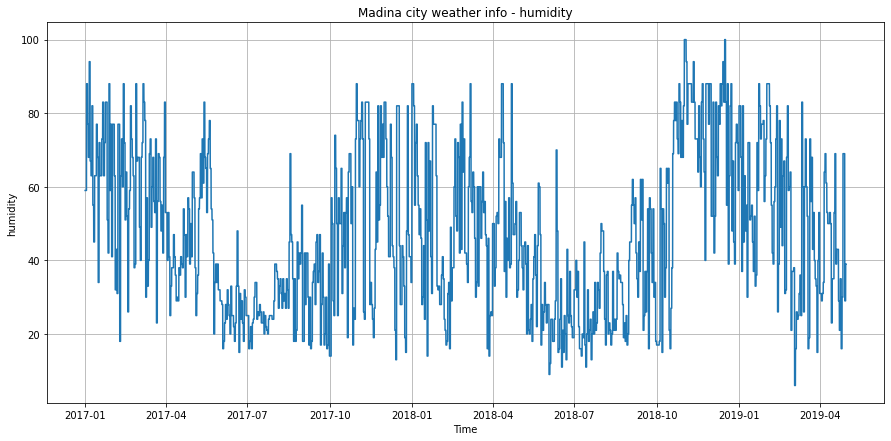

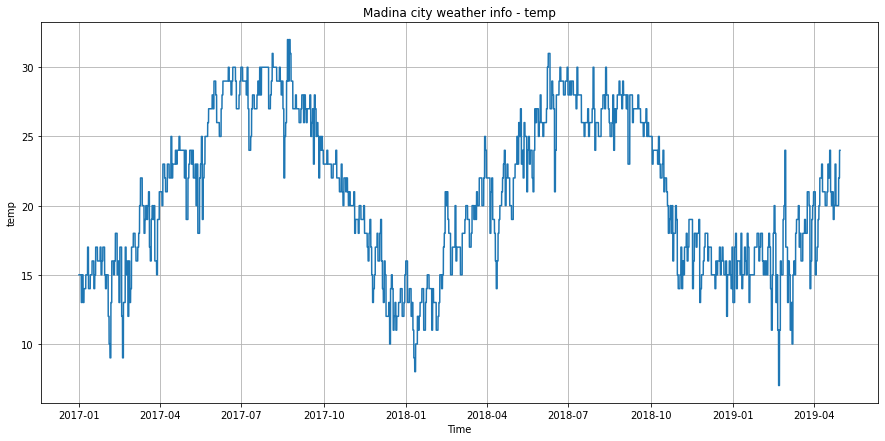

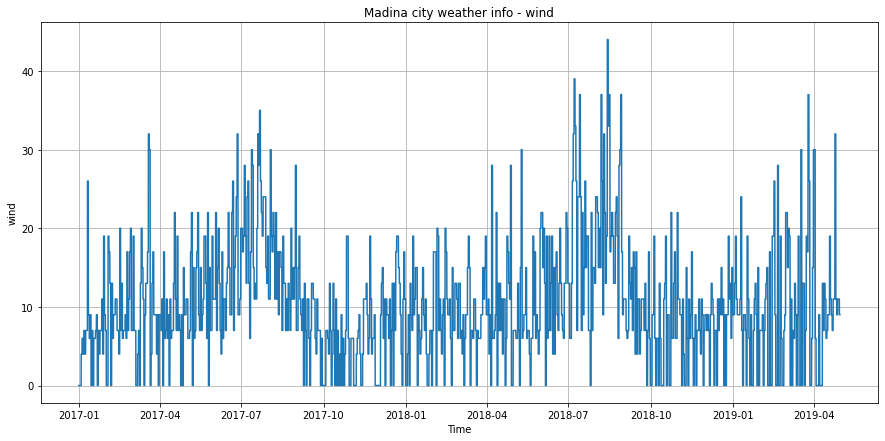

In [18]:
# weather info used in forcasting
weather_info = ['humidity', 'temp','wind']
series = df_cities_lst[city_index][weather_info].values
time = np.array(df_cities_lst[2].index)

# plot Baha weather info
for ind, weather_i in enumerate(weather_info):
    plt.figure(figsize=(15, 7))
    plot_series(time, series[:, ind], fig_title=f"Madina city weather info - {weather_i}", y_label=weather_i)
    plt.show()

In [19]:
# split our data to train and text data
split_time = 4700 # where test data starts
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# number of features (points) used to predict next point after this window
window_size = 64

# For training we need to create batches (set of rows(X) with corresponding y)
batch_size = 256

# It will just fill the buffer with the first 'shuffle_buffer_size' elements, pick one of them at random. 
# And then it will replace that with the 'shuffle_buffer_size' element and first element before randomly picking again, and so on. 
# using a shuffle buffer speeds things up a bit.
shuffle_buffer_size = 1000


In [20]:
def windowed_dataset_multivariate_var(series, window_size, batch_size, shuffle_buffer):
    '''Function used to divide our multivariate series to windows since each window contains number of points
       we will consider then as features to predict the next value after this window'''


    # create a dataset from the series using a tf.data dataset.
    ds = tf.data.Dataset.from_tensor_slices(series)

    # convert series to following form:
    # row1: 0-30 points 
    # row2: 1-31 points 
    # row3: 2-32 points and so on
    # every time we shift by one point 
    # here it add 1 to window size bcz (feature num + label)
    # drop_remainder: is useful at the end to delete last rows that don't have enough features 
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    # put these windows into numpy lists so that we can start using them with machine learning.
    # ex :
    # row1 (window1): 1 2 3 4 5 => [1 2 3 4 5]
    # row2 (window2): 2 3 4 5 6 => [2 3 4 5 6] and so on
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # shuffle our data (rows) before training.
    ds = ds.shuffle(shuffle_buffer)

    # divide each row to 'window_size' as features and 1 as lebal
    # ex:
    # row1: [1 2 3 4 5] => [1 2 3 4] [5]
    ds = ds.map(lambda w: (w[:-1], w[1:]))

    # batch the data into sets of 'batch_size'
    return ds.batch(batch_size).prefetch(1)

In [21]:
def model_forecast_multivariate(imodel, series, window_size):
    """Function to divide series to windows then forcast next values for each window in a series data"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = imodel.predict(ds)
    return forecast

In [25]:
# clear tensorflow session
tf.keras.backend.clear_session()

# Setting seed to ensure reproducibility.
tf.random.set_seed(50)
np.random.seed(50)

# preprocess series data
train_set = windowed_dataset_multivariate_var(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 3), (None, None, 3)), types: (tf.float64, tf.float64)>
(4700, 3)


In [26]:
# Build deep learning model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 3]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: x * 400)
  # The default activation function in the RNN layers is tan H which is the hyperbolic tangent activation. 
  # This outputs values between negative one and one. Since the time series values are in that order usually in 
  # the 10s like 40s, 50s, 60s, and 70s, then scaling up the outputs to the same ballpark can help us with learning
])

# change learning rate during training
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
# set optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# compile and fit model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
19/19 [==============================] - 1s 35ms/step - loss: 40.8978 - mae: 41.3946 - lr: 1.0000e-08
Epoch 2/100
19/19 [==============================] - 1s 31ms/step - loss: 39.7204 - mae: 40.2172 - lr: 1.1220e-08
Epoch 3/100
19/19 [==============================] - 1s 31ms/step - loss: 38.3290 - mae: 38.8254 - lr: 1.2589e-08
Epoch 4/100
19/19 [==============================] - 1s 32ms/step - loss: 36.9618 - mae: 37.4580 - lr: 1.4125e-08
Epoch 5/100
19/19 [==============================] - 1s 31ms/step - loss: 35.6667 - mae: 36.1627 - lr: 1.5849e-08
Epoch 6/100
19/19 [==============================] - 1s 31ms/step - loss: 34.4421 - mae: 34.9377 - lr: 1.7783e-08
Epoch 7/100
19/19 [==============================] - 1s 31ms/step - loss: 33.2777 - mae: 33.7729 - lr: 1.9953e-08
Epoch 8/100
19/19 [==============================] - 1s 37ms/step - loss: 32.1563 - mae: 32.6513 - lr: 2.2387e-08
Epoch 9/100
19/19 [==============================] - 1s 32ms/step - loss: 31.0680 - mae:

(1e-08, 0.001, 0.0, 100.0)

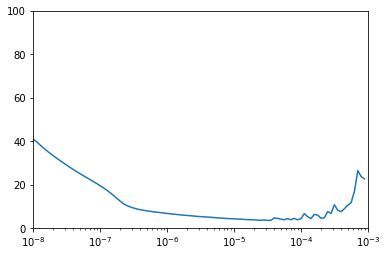

In [33]:
# plot learning rate to pick next start point for lr
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 0.001, 0, 100])

In [34]:
# forcast weather info using above model

rnn_forecast = model_forecast_multivariate(model, series, window_size)
# split_time - window_size:-1 => we forcasted whole data, so need to just pick valid data 
# -1 => it's repeated as window size, just get last value to be label
# 0 => convert [23] to 23
rnn_forecast_ = rnn_forecast[split_time - window_size:-1, -1, :]

In [35]:
# check sum shapes
print('input data shape: ', series.shape)
print('forcasted data shape: ', rnn_forecast.shape)
print('forcasted data after fixing shape: ', rnn_forecast_.shape)

input data shape:  (6793, 3)
forcasted data shape:  (6730, 64, 3)
forcasted data after fixing shape:  (2093, 3)


In [38]:
# show forcasted result (forcasting temperature)
print(rnn_forecast_[:,1])

[39.822037 39.822037 39.822037 ... 39.822037 39.822037 39.822037]


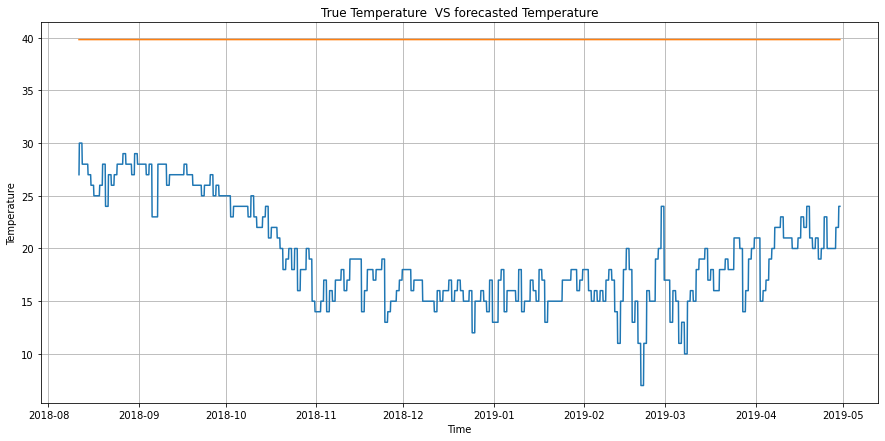

In [39]:
# plot forcasting data (forcasting temperature)
plt.figure(figsize=(15, 7))
plot_series(time_valid, x_valid[:,1], fig_title="True Temperature  VS forecasted Temperature", y_label='Temperature')
plot_series(time_valid, rnn_forecast_[:,1], fig_title="True Temperature  VS forecasted Temperature", y_label='Temperature')

In [67]:
# we'll use best learning rate from figure above to build better model
# prepare new model
tf.keras.backend.clear_session()

# Setting seed to ensure reproducibility.
tf.random.set_seed(50)
np.random.seed(50)

# prepare data
window_size = 60
batch_size = 100
train_set = windowed_dataset_multivariate_var(x_train, window_size, batch_size, shuffle_buffer_size)

In [68]:
# build new model
model_m = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 3]),
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer_m = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)
model_m.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer_m,
              metrics=["mae"])
history_m = model_m.fit(train_set,epochs=150)

Epoch 1/150
47/47 [==============================] - 1s 16ms/step - loss: 7.9633 - mae: 8.4437
Epoch 2/150
47/47 [==============================] - 1s 16ms/step - loss: 3.5196 - mae: 3.9797
Epoch 3/150
47/47 [==============================] - 1s 17ms/step - loss: 2.9193 - mae: 3.3694
Epoch 4/150
47/47 [==============================] - 1s 19ms/step - loss: 2.6224 - mae: 3.0662
Epoch 5/150
47/47 [==============================] - 1s 17ms/step - loss: 2.4361 - mae: 2.8744
Epoch 6/150
47/47 [==============================] - 1s 16ms/step - loss: 2.2775 - mae: 2.7099
Epoch 7/150
47/47 [==============================] - 1s 17ms/step - loss: 2.1925 - mae: 2.6215
Epoch 8/150
47/47 [==============================] - 1s 18ms/step - loss: 2.0925 - mae: 2.5158
Epoch 9/150
47/47 [==============================] - 1s 17ms/step - loss: 2.0775 - mae: 2.5030
Epoch 10/150
47/47 [==============================] - 1s 16ms/step - loss: 2.0417 - mae: 2.4669
Epoch 11/150
47/47 [=============================

In [69]:
# forcast weather info using above model

rnn_forecast = model_forecast_multivariate(model_m, series, window_size)
# split_time - window_size:-1 => we'hv forcasted whole data, so need to just pick valid data 
# -1 => it's repeated as window size, just get last value to be label
# 0 => convert [23] to 23
rnn_forecast_ = rnn_forecast[split_time - window_size:-1, -1, :]

In [70]:
# check sum shapes
print('input data shape: ', series.shape)
print('forcasted data shape: ', rnn_forecast.shape)
print('forcasted data after fixing shape: ', rnn_forecast_.shape)

input data shape:  (6793, 3)
forcasted data shape:  (6734, 60, 3)
forcasted data after fixing shape:  (2093, 3)


In [71]:
# show forcasted result (forcasting temperature)
print(rnn_forecast_[:,1])

[27.251953 27.280804 27.816332 ... 22.896376 23.913733 24.266361]


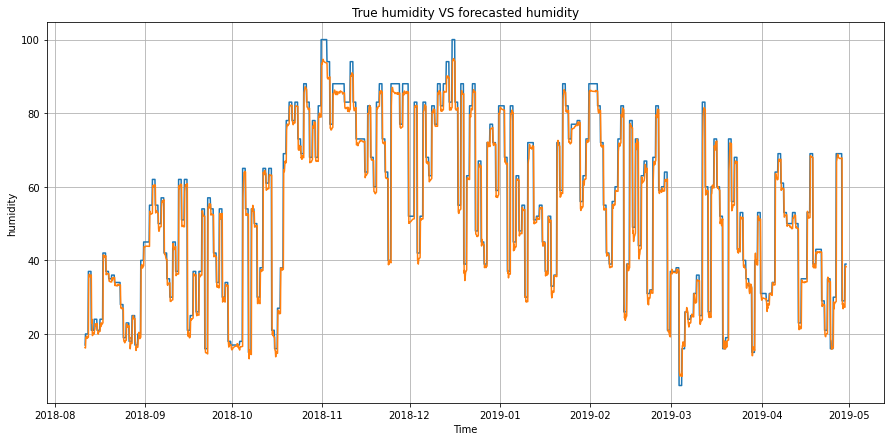

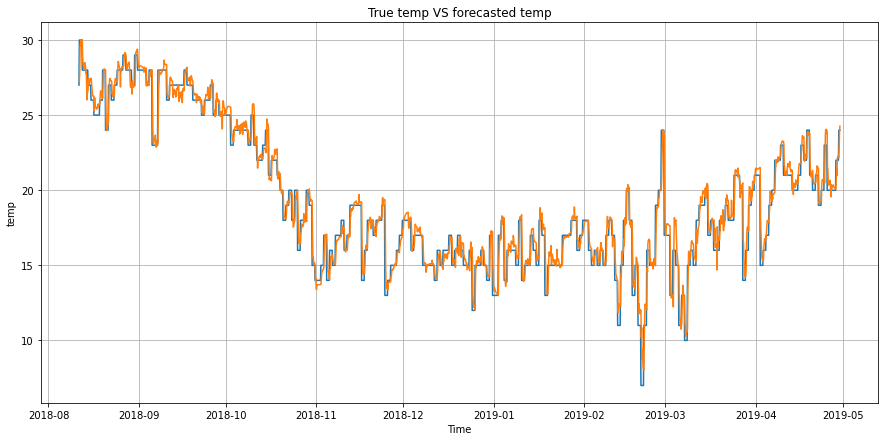

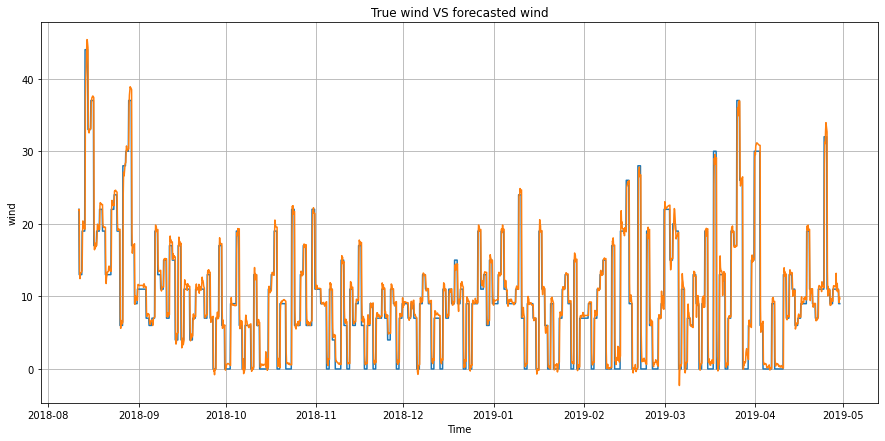

In [72]:
# plot Baha forcasted weather info
for ind, weather_i in enumerate(weather_info):
    plt.figure(figsize=(15, 7))
    plot_series(time_valid, x_valid[:,ind], fig_title=f"True {weather_i} VS forecasted {weather_i}", y_label=weather_i)
    plot_series(time_valid, rnn_forecast_[:,ind], fig_title=f"True {weather_i} VS forecasted {weather_i}", y_label=weather_i)
    plt.show()

In [75]:
# loss/error
for ind, weather_i in enumerate(weather_info):
    print(f"Error of forecasting {weather_i} is {tf.keras.metrics.mean_absolute_error(x_valid[:, ind], rnn_forecast_[:,ind]).numpy()}")

Error of forecasting humidity is 2.9437458515167236
Error of forecasting temp is 0.5701051354408264
Error of forecasting wind is 1.3618710041046143


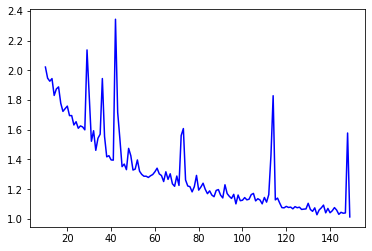

In [73]:
# Plot loss starting from 10th loss
loss = history_m.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()